In [216]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [217]:
# Loading the CSV file
iris_df = pd.read_csv("C:/Users/Salma/Downloads/iris.csv")

In [218]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [219]:
print(iris_df.isnull().sum())  # Check for Null values

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


In [220]:
# Drop any rows with Null values
iris_df = iris_df.dropna()

In [221]:
X = iris_df.iloc[:, :-1].values 
y = iris_df['species'] 

In [222]:
# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert target to numeric values

In [223]:
# One-hot encode the target labels for multiclass classification
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y_encoded.reshape(-1, 1))

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Convert the datasets into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [224]:
# Define the Neural Network Model
class IrisModel(nn.Module):
    def __init__(self):
        super(IrisModel, self).__init__()
        self.fc1 = nn.Linear(4, 128)  # Inputs are 4 features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)   # Outputs are 3 classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # For multiclass classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return self.softmax(x) # SoftMax give probability for each class


In [225]:
# Initialize the model
model = IrisModel()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [226]:
# Training the Model
def train_model(model, X_train, y_train, epochs=60):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_train)

        # Compute loss
        loss = criterion(y_pred, torch.max(y_train, 1)[1]) 

        # Backpropagation 
        loss.backward()
        
        # optimization
        optimizer.step()
        
        loss_history.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return loss_history

In [227]:
# Train the model
loss_history = train_model(model, X_train_tensor, y_train_tensor)

# Evaluate the Model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_class = torch.argmax(y_test_pred, axis=1).numpy()

# Convert true labels back to their original form
y_test_true = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_true, y_test_pred_class)
print(f'Accuracy: {accuracy:.3f}')

Epoch [10/60], Loss: 1.0162
Epoch [20/60], Loss: 0.8852
Epoch [30/60], Loss: 0.7818
Epoch [40/60], Loss: 0.7172
Epoch [50/60], Loss: 0.6693
Epoch [60/60], Loss: 0.6284
Accuracy: 1.000


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


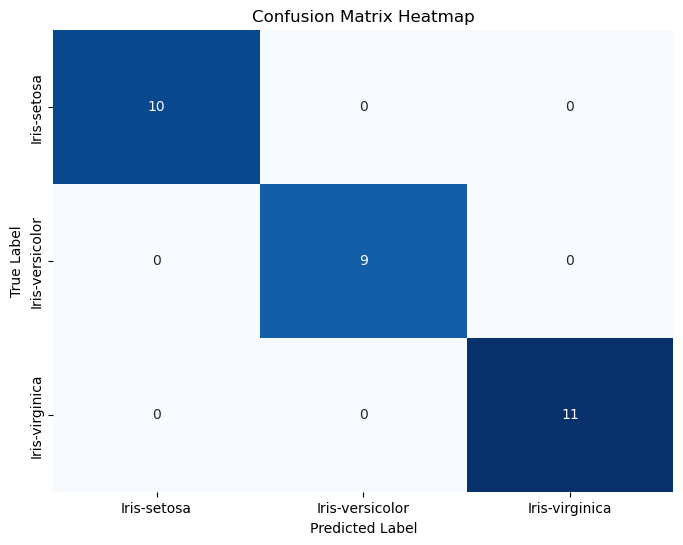

In [228]:
import seaborn as sns

# computing the confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred_class)
print('Confusion Matrix:')
print(conf_matrix)

# Plotting the heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(r"C:\Users\Salma\Desktop\heatmapMulti.png", format='png')
plt.show()

In [229]:
# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_true, y_test_pred_class, average='macro')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


ROC-AUC Score (One-vs-Rest): 1.0000


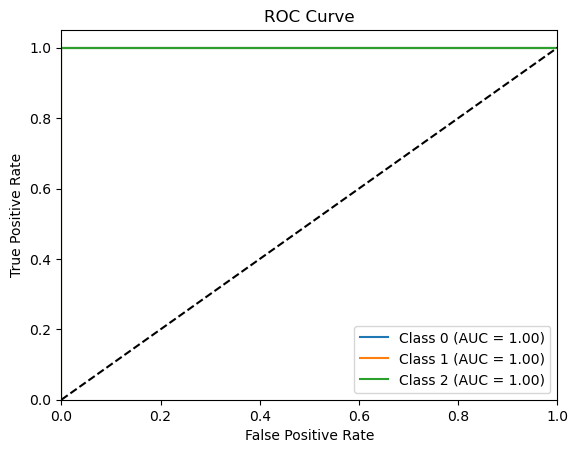

In [230]:
# ROC-AUC Curve for Multiclass (One-vs-Rest)
y_test_true_onehot = encoder.transform(y_test_true.reshape(-1, 1))  # Transform true labels to one-hot
roc_auc = roc_auc_score(y_test_true_onehot, y_test_pred.numpy(), multi_class='ovr')
print(f'ROC-AUC Score (One-vs-Rest): {roc_auc:.4f}')

# ROC Curve for each class
fpr = {}
tpr = {}
thresholds = {}

for i in range(3):  # For each class
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_true_onehot[:, i], y_test_pred[:, i])

# Plot ROC Curve
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_score(y_test_true_onehot[:, i], y_test_pred[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig(r"C:\Users\Salma\Desktop\ROC_Multi.png", format='png')
plt.show()

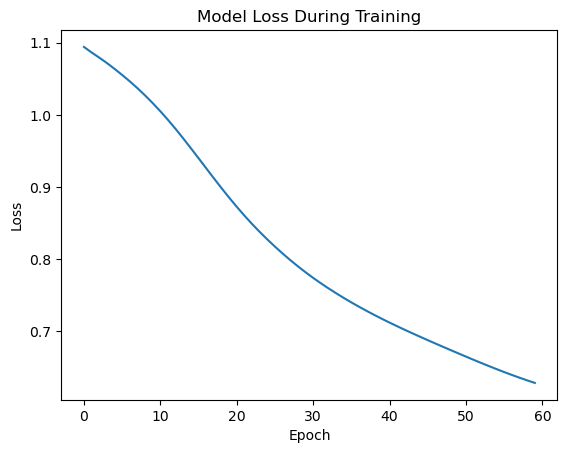

In [231]:
# Visualizing Loss during Training
plt.plot(loss_history)
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(r"C:\Users\Salma\Desktop\LossMulti.png", format='png')
plt.show()